In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

def savefig(filename):
    plt.savefig('{}.eps'.format(filename))
    plt.savefig('{}.png'.format(filename))

0: origin=[0 0 0], origin_vel=[0.5 0.  0. ], dest=[5 2 0], dest_vel=[1 2 0], duration=20, dt=0.05 0
1: origin=[5 2 0], origin_vel=[1 2 0], dest=[2 4 0], dest_vel=[-0.5  0.   0. ], duration=20, dt=0.05 20
(800,)
(800, 3) (800, 3)
(800, 3) (800, 3)
(20,) (20, 3) (20, 3)
(20,) (20, 3) (20, 3)


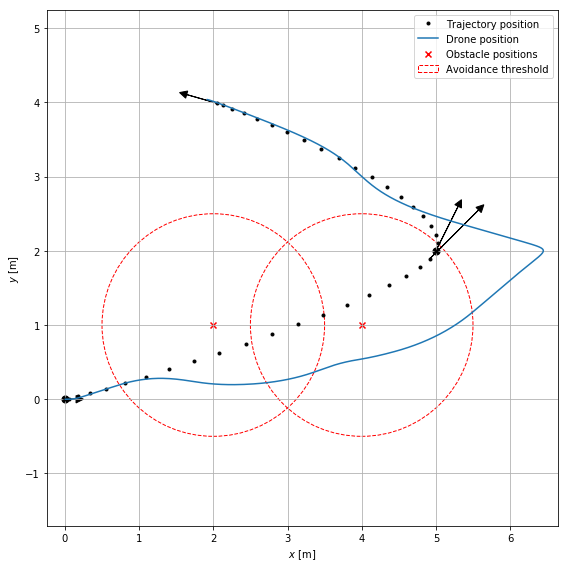

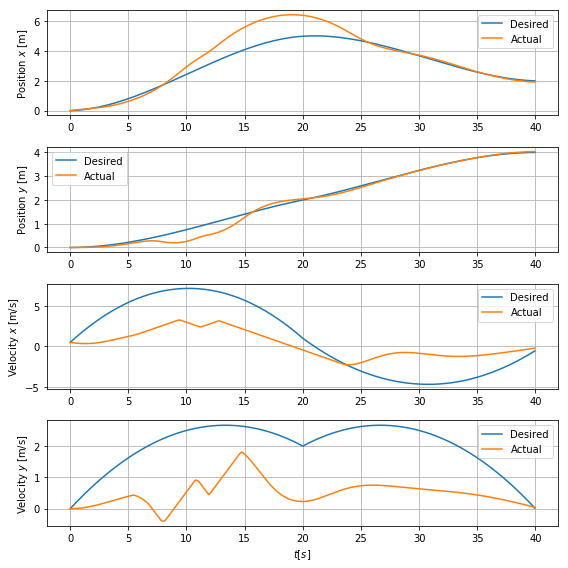

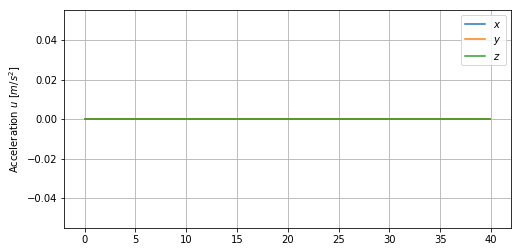

In [31]:
class HermiteSpline():
    """
    This class represents a 2D cubic hermite spline connecting the `origin` and `dest` points
    with velocity constraints `origin_vel` and `dest_vel`   
    """
    def __init__(self, origin, origin_vel, dest, dest_vel, dt=0.01, duration=None):
        self.origin = origin
        self.origin_vel = origin_vel
        self.dest = dest
        self.dest_vel = dest_vel
        self.dt = dt
        self.t = np.arange(0, 1, self.dt)
        self.duration = duration
        
        self._H = np.array([
            origin, # h1
            origin_vel, # h2
            -3*origin - 2*origin_vel + 3*dest - dest_vel, # h3
            2*origin + origin_vel - 2*dest + dest_vel # h4
        ]).T
        self._T  = np.array([np.ones_like(self.t), self.t, np.power(self.t, 2), np.power(self.t, 3)])
        self._dT = np.array([np.zeros_like(self.t), np.ones_like(self.t), 2*self.t, 3*np.power(self.t, 2)])

        self.x = np.transpose(self._H.dot(self._T))
        self.v = np.transpose(self._H.dot(self._dT))
    
    def get_polynomial(self):
        """Get an array with the Hermite spline coefficients h1..h4"""
        return self._H
        
    def sample(self, t):
        """
        Sample the trajectory at an arbitrary time `t` on the range <0, 1>.
        """
        x = self._H.dot(np.array([1.0, t, t**2, t**3]))
        v = self._H.dot(np.array([0.0, 1.0, 2*t, 3*t**2]))
        return x, v
    
    def __repr__(self):
        return "origin={}, origin_vel={}, dest={}, dest_vel={}, duration={}, dt={}".format(
            self.origin, self.origin_vel, self.dest, self.dest_vel, self.duration, self.dt)
    

class HSplineTrajectory():
    """
    This class represents a trajectory consiting of multiple connected HermiteSpline segments. 
    Origin position and velocity of the next segment are identical to destination position and velocity
    of the previous segment.
    """
    def __init__(self, origin, origin_vel):
        """
        Initialize a segmented Hermite spline trajectory. Initial state is given by `origin` (position)
        and `origin_vel` (velocity). Additional segments can be added with `add_cont_segment()`
        """
        # List for storing HermiteSpline trajectory segments
        self.hsplines = []
        self.start_times = []
        # Initial position and velocity used to create the first segment
        self.origin = origin
        self.origin_vel = origin_vel
        self.total_duration = 0
    
    def add_cont_segment(self, dest, dest_vel, duration, dt=0.05):
        """
        Add a new continuous HermiteSpline segment. Origin of the new segment will be set identical to
        the destination of the last segment in the current trajectory.
        """
        if len(self.hsplines) == 0:
            origin = self.origin
            origin_vel = self.origin_vel
            self.start_times.append(0)
        else:
            origin = self.hsplines[-1].dest
            origin_vel = self.hsplines[-1].dest_vel
            self.start_times.append(self.start_times[-1] + duration)
        self.total_duration += duration    
        self.hsplines.append(HermiteSpline(origin, origin_vel, dest, dest_vel, dt, duration))
        
    def sample(self, t):
        """
        Sample the trajecoty at an arbitrary time `t` on the range <0, total_duration>.
        """
        # If we're sampling outside of the total duration, return the end point of last spline segment
        if t > self.total_duration:
            return self.hsplines[-1].sample(1)
        # Else look up the current spline segment according to `t`
        i = len(self.hsplines) - 1
        while i >= 0:
            start_time = self.start_times[i]
            if t >= start_time:
                t_segment = (t - start_time) / self.hsplines[i].duration
#                 print("sample traj {} t={} t_seg={}".format(i, t, t_segment))
                return self.hsplines[i].sample(t_segment)
            i -= 1
        return None, None
        
    def get_total_duration(self):
        return self.total_duration
    
    def print_trajectory(self):
        for i, hs in enumerate(self.hsplines):
            print("{}: {} {}".format(i, hs, self.start_times[i]))


class Drone():
    def __init__(self, origin, origin_vel, hspline, obstacles, duration, dt, 
                 setpoint_gain, velocity_gain, velocity_ff_gain, obstacle_gain, max_vel, max_accel,
                 r_obstacle):
        self.t = np.arange(0, duration, dt) # Simulation time vector
        self.dt = dt # Simulation time step
        self.duration = duration # Simulation duration
        self.num_steps = len(self.t) # Number of simulation time steps
        
        # Parameters
        self.setpoint_gain = setpoint_gain # Trajectory position controller gain
        self.velocity_gain = velocity_gain # Velocity controller gain
        self.velocity_ff_gain = velocity_ff_gain # Trajectory velocity feedforward gain
        self.obstacle_gain = obstacle_gain # Obstacle avoidance gain
        self.r_obstacle = r_obstacle # Obstacle avoidance radius (only consider obstacles closer than this)
        # Velocity and acceleration is clamped to +-max_vel / +-max_accel
        self.max_vel = max_vel 
        self.max_accel = max_accel
        
        # Current state
        self.position = origin * 1.0 if origin is not None else np.zeros(3)
        self.velocity = origin_vel * 1.0 if origin_vel is not None else np.zeros(3)
        self.accelertion = np.zeros(3)
        
        # State history
        self.x = np.zeros((self.num_steps, 3)) # Pos 
        self.v = np.zeros((self.num_steps, 3)) # Vel
        self.a = np.zeros((self.num_steps, 3)) # Control input
        self.x[0] = self.position # Fill in the first values
        self.v[0] = self.velocity
        self.a[0] = self.accelertion
        # Desired position and velocity from trajectory
        self.x_traj = np.zeros((self.num_steps, 3)) # Pos 
        self.v_traj = np.zeros((self.num_steps, 3)) # Vel
        
        self.hspline = hspline # HSpline trajectory
        self.obstacles = obstacles # List of obstacle positions
        
    def step(self, accel, step_idx, dt=.01):
        self.velocity += accel * dt
        self.position += self.velocity * dt # velocity[:2]
        self.acceleration = accel
        self.x[step_idx] = self.position
        self.v[step_idx] = self.velocity
        self.a[step_idx] = self.accelertion
        
    def circular_field_avoidance(self, obstacle_pos):
        # Position error
        distance = self.position - obstacle_pos
        # Assuming static obstacles -> obstacle velocity = 0
        vel_error = self.velocity # - 0
        direction = -distance / (np.linalg.norm(distance) + 1e-6)
        vel_error_normalized = -vel_error / (np.linalg.norm(vel_error) + 1e-6)
        # Circular field obstacle acceleration
        b = np.cross(direction, vel_error_normalized) / np.linalg.norm(distance)**2
        accel = self.obstacle_gain * np.cross(direction, b)
        # This order would give us the opposite (attractive) force
        # accel = self.obstacle_gain * np.cross(b, direction)
        return accel
        
    def simulate(self):
        for step in range(self.num_steps):
            accel_command = np.zeros(3)
            velocity_command = np.zeros(3)
            obstacle_accel = np.zeros(3)
            
            # Sample the desired position and velocity from HSpline
            x_traj, v_traj = self.hspline.sample(self.t[step])
            self.x_traj[step] = x_traj
            self.v_traj[step] = v_traj
            # Trajectory tracking controller
            velocity_command = self.setpoint_gain * (x_traj - self.position) + self.velocity_ff_gain * (v_traj-self.velocity)
            
            # Obstacle avoidance
            for obstacle_pos in self.obstacles:
                # S: distance = obs_position - states[drone].position
                distance = self.position - obstacle_pos
                dist = np.linalg.norm(distance)
                # Only avoid obstacles that are closer than a threshold distance
                if dist < self.r_obstacle:
                    obstacle_accel += self.circular_field_avoidance(obstacle_pos)
                    
            # Simple velocity controller
            velocity_command = np.clip(velocity_command, -self.max_vel, self.max_vel)
            accel_command = self.velocity_gain * (velocity_command - self.velocity)
            
            # Add obstacle accels
            accel_command[:3] += obstacle_accel
            accel_command = np.clip(accel_command, -self.max_accel, self.max_accel)
            
            self.step(accel_command, step)

# Origin and destination position and velocity
origin = np.array([0, 0, 0])
origin_vel = np.array([0.5, 0, 0])
dt = 1.0 / 20.0 # Simulation time step
# Duration of simulation (must be higher than the sum of trajectory segment durations below)
sim_duration = 40.0
hst = HSplineTrajectory(origin, origin_vel)
hst.add_cont_segment(dest=np.array([5, 2, 0]), dest_vel=np.array([1, 2, 0]), duration=20, dt=dt)
hst.add_cont_segment(dest=np.array([2, 4, 0]), dest_vel=np.array([-0.5, 0, 0]), duration=20, dt=dt)
hst.print_trajectory()

# List of obstacle positions
obstacles = np.array([
    [2, 1, 0],
    [4, 1, 0],
])
r_obstacle = 1.5 # Obstacle avoidance radius

# Create the drone simulator object with parameters
drone = Drone(origin, origin_vel, hst, obstacles, sim_duration, dt,
              setpoint_gain=5.0, velocity_gain=2.0, velocity_ff_gain=0.25, obstacle_gain=10.0,
              max_vel=5.0, max_accel=2.5,
              r_obstacle=r_obstacle)
drone.simulate()


print(drone.t.shape)
print(drone.x.shape, drone.v.shape)
print(drone.x_traj.shape, drone.v_traj.shape)

#### Plots
figsize = (8, 8)
vscale = 0.3
save_pdf = False

# XY view
plt.figure(figsize=figsize)
# Plot individual HSpline segments
for hs in hst.hsplines:
    print(hs.t.shape, hs.x.shape, hs.v.shape)
    # Desired position sampled from the trajectory
    h_hspline, = plt.plot(hs.x[:, 0], hs.x[:, 1], 'k.', label='HSpline traj')
    # Show nitial position of the trajectory with a larger marker
    plt.scatter(hs.x[0, 0], hs.x[0, 1], c='k', marker='o', s=50)
    # Draw initial and final velocities as arrows
    ax = plt.gca()
    ax.arrow(hs.x[0,0], hs.x[0,1], # x, y
             hs.v[0,0]*vscale, hs.v[0,1]*vscale, # dx, dy
             head_width=0.1, head_length=0.1, fc='k', ec='k')
    ax.arrow(hs.x[-1,0], hs.x[-1,1], # x, y
             hs.v[-1,0]*vscale, hs.v[-1,1]*vscale, # dx, dy
             head_width=0.1, head_length=0.1, fc='k', ec='k')
# Drone position
h_dronepos, = plt.plot(drone.x[:,0], drone.x[:,1], label='Drone pos')
# Obstacles
h_obstacles = plt.scatter(obstacles[:,0], obstacles[:,1], c='r', marker='x', label='Obstacles')
# Plot avoidance radius circle around each obstacle
for obstacle_pos in obstacles:
    circle = plt.Circle(obstacle_pos, r_obstacle, color='r', linestyle='--', fill=False)
    h_avoidance = plt.gca().add_patch(circle)
plt.grid(True)
plt.axis('equal')
plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
plt.legend(handles=[h_hspline, h_dronepos, h_obstacles, h_avoidance],
           labels=['Trajectory position', 
                   'Drone position', 
                   'Obstacle positions', 
                   'Avoidance threshold'])
plt.tight_layout()
if save_pdf: savefig("plots/avoidance_xy")


plt.figure(figsize=(8,8))
plt.subplot(411)
plt.grid(True)
plt.plot(drone.t, drone.x_traj[:, 0], label='Desired')
plt.plot(drone.t, drone.x[:, 0], label='Actual')
# plt.xlabel('$t$')
plt.ylabel('Position $x$ [m]')
plt.legend()

plt.subplot(412)
plt.grid(True)
plt.plot(drone.t, drone.x_traj[:, 1], label='Desired')
plt.plot(drone.t, drone.x[:, 1], label='Actual')
# plt.xlabel('$t$')
plt.ylabel('Position $y$ [m]')
plt.legend()

plt.subplot(413)
plt.grid(True)
plt.plot(drone.t, drone.v_traj[:, 0], label='Desired')
plt.plot(drone.t, drone.v[:, 0], label='Actual')
# plt.xlabel('$t$')
plt.ylabel('Velocity $x$ [m/s]')
plt.legend()

plt.subplot(414)
plt.grid(True)
plt.plot(drone.t, drone.v_traj[:, 1], label='Desired')
plt.plot(drone.t, drone.v[:, 1], label='Actual')
plt.xlabel('$t [s]$')
plt.ylabel('Velocity $y$ [m/s]')
plt.legend()
plt.tight_layout()
if save_pdf: savefig("plots/avoidance_t")

# Acceleration control input
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(drone.t, drone.a[:, 0], label='$x$')
plt.plot(drone.t, drone.a[:, 1], label='$y$')
plt.plot(drone.t, drone.a[:, 2], label='$z$')
# plt.xlabel('$t$')
plt.ylabel('Acceleration $u$ [$m/s^2$]')
plt.legend()


In [3]:
# drone.t

(50,) (50, 50) (50, 50)


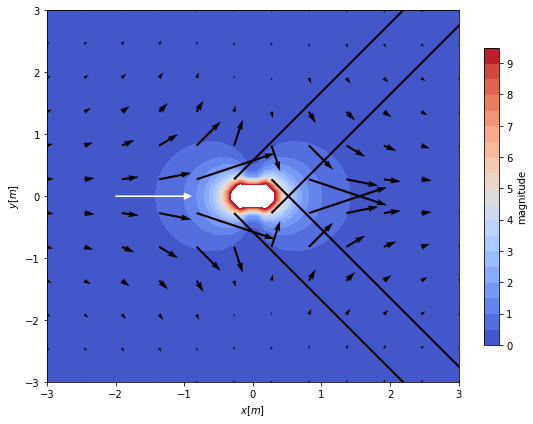

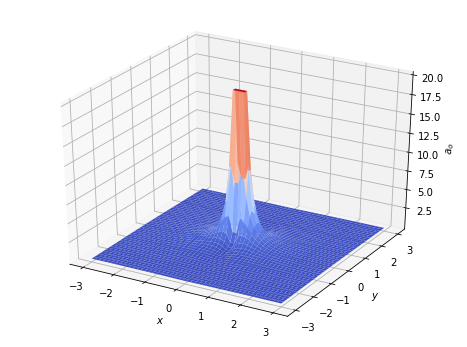

In [4]:
# Circular field quiver plot
drone_test = Drone(origin, origin_vel, hs, obstacles, sim_duration, dt,
              setpoint_gain=5.0, velocity_gain=2.0, velocity_ff_gain=0.25, obstacle_gain=1.0,
              max_vel=5.0, max_accel=2.5,
              r_obstacle=r_obstacle)

drone_vel = np.array([1,0,0])
drone_test.position = np.array([0,0,0])
drone_test.velocity = drone_vel

size = 3
# step = 0.5
N_quiver = 12
N_contour = 50
contour = True
save_pdf = False
figsize=(8,6)

plt.figure(figsize=figsize)

Xc = np.linspace(-size, size, N_contour) # np.arange(-size, size, step)
Yc = np.linspace(-size, size, N_contour) # np.arange(-size, size, step)
Xxc, Yyc = np.meshgrid(Xc, Yc)
magnitude = []
for x in Xc:
    for y in Yc:
        drone_test.position = np.array([x, y, 0])
        obstacle = np.zeros(3)
        magnitude.append(np.linalg.norm(drone_test.circular_field_avoidance(obstacle)))
Z = np.array(magnitude).reshape(N_contour, N_contour)

if contour:
    fig1 = plt.gcf()
    ax1 = plt.gca()
    CS = ax1.contourf(Xxc, Yyc, Z, levels=np.arange(0,10,0.5), cmap=cm.coolwarm)
    # Make a colorbar for the ContourSet returned by the contourf call.
    cbar = fig1.colorbar(CS, shrink=0.8)
    cbar.ax.set_ylabel('magnitude')
    # Add the contour line levels to the colorbar
    # cbar.add_lines(CS2)

Xq = np.linspace(-size, size, N_quiver) # np.arange(-size, size, step)
Yq = np.linspace(-size, size, N_quiver) # np.arange(-size, size, step)
Xxq, Yyq = np.meshgrid(Xq, Yq)
accel = []
for x in Xq:
    for y in Yq:
        drone_test.position = np.array([x, y, 0])
        obstacle = np.zeros(3)
        accel.append(drone_test.circular_field_avoidance(obstacle))
accel = np.array(accel)        
plt.quiver(Xxq, Yyq, accel[:,0], accel[:,1])
ax = plt.gca()
ax.arrow(-2*drone_vel[0], -2*drone_vel[1], # x, y
         drone_vel[0], drone_vel[1], # x+dx, y+dy
         head_width=0.1, head_length=0.1, fc='w', ec='w')
plt.xlim((-size, size))
plt.ylim((-size, size))
plt.xlabel(r'$x [m]$')
plt.ylabel(r'$y [m]$')
# plt.axis('equal')
plt.tight_layout()
if save_pdf: savefig("plots/circfield_quiver")
print(Xc.shape, Xxc.shape, Z.shape)
# print(accel)

# 3D plot of circular field magnitude 
fig = plt.figure(figsize=figsize)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Xxc, Yyc, np.clip(Z, 0, 20), cmap=cm.coolwarm, vmax=20,
                       linewidth=0, antialiased=True)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$a_o$')
if save_pdf: savefig('plots/circfield_3d')

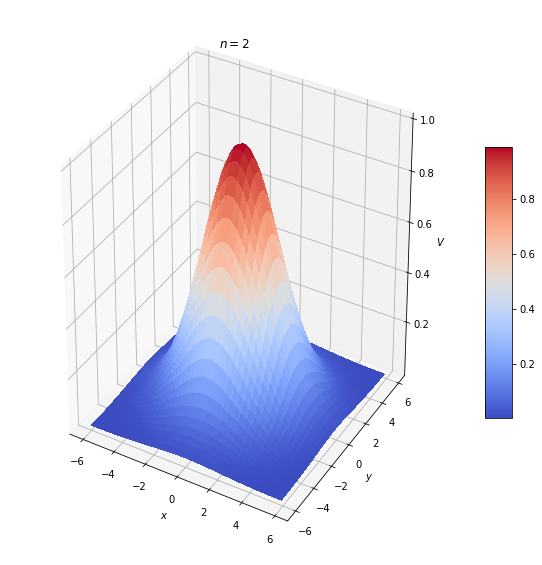

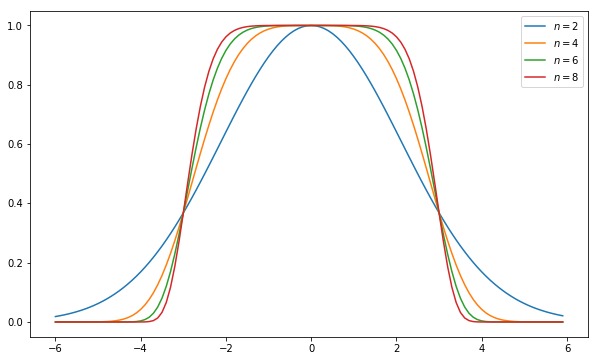

In [5]:
# Repulsive potential function from Santos et al. 2017 "A Novel Null-Space-Based UAV Trajectory Tracking Controller With Collision Avoidance"
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8049328
n = 2
a = 3
b = 3
size = 6

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-size, size, 0.1)
Y = np.arange(-size, size, 0.1)
XX, YY = np.meshgrid(X, Y)
V = np.exp(-(XX/a)**n - (YY/b)**n)

# # Plot the surface.
surf = ax.plot_surface(XX, YY, V, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title(r'$n=2$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$V$')
# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.figure(figsize=(10,6))
for n in [2, 4, 6, 8]:
    Vx = np.exp(-(X/a)**n)
    plt.plot(X, Vx, label=r'$n={}$'.format(n))
plt.legend()
plt.show()

In [6]:
# HSplineTrajectory sampling test
hst = HSplineTrajectory(origin=np.array([0, 0, 0]), origin_vel=np.array([0, 0, 0]))
hst.add_cont_segment(dest=np.array([2, 2, 0]), dest_vel=np.array([1, 1, 0]), duration=5)
hst.add_cont_segment(dest=np.array([3, 2, 0]), dest_vel=np.array([0, 0, 0]), duration=5)
hst.print_trajectory()
for t in np.arange(0, 10, 0.5):
    p, v = hst.sample(t)
    print("{:.2f} {} {}".format(t, p, v))

0: origin=[0 0 0], origin_vel=[0 0 0], dest=[2 2 0], dest_vel=[1 1 0], duration=5, dt=0.05 0
1: origin=[2 2 0], origin_vel=[1 1 0], dest=[3 2 0], dest_vel=[0 0 0], duration=5, dt=0.05 5
0.00 [0. 0. 0.] [0. 0. 0.]
0.50 [0.047 0.047 0.   ] [0.91 0.91 0.  ]
1.00 [0.176 0.176 0.   ] [1.64 1.64 0.  ]
1.50 [0.369 0.369 0.   ] [2.19 2.19 0.  ]
2.00 [0.608 0.608 0.   ] [2.56 2.56 0.  ]
2.50 [0.875 0.875 0.   ] [2.75 2.75 0.  ]
3.00 [1.152 1.152 0.   ] [2.76 2.76 0.  ]
3.50 [1.421 1.421 0.   ] [2.59 2.59 0.  ]
4.00 [1.664 1.664 0.   ] [2.24 2.24 0.  ]
4.50 [1.863 1.863 0.   ] [1.71 1.71 0.  ]
5.00 [2. 2. 0.] [1. 1. 0.]
5.50 [2.109 2.081 0.   ] [1.17 0.63 0.  ]
6.00 [2.232 2.128 0.   ] [1.28 0.32 0.  ]
6.50 [2.363 2.147 0.   ] [1.33 0.07 0.  ]
7.00 [2.496 2.144 0.   ] [ 1.32 -0.12  0.  ]
7.50 [2.625 2.125 0.   ] [ 1.25 -0.25  0.  ]
8.00 [2.744 2.096 0.   ] [ 1.12 -0.32  0.  ]
8.50 [2.847 2.063 0.   ] [ 0.93 -0.33  0.  ]
9.00 [2.928 2.032 0.   ] [ 0.68 -0.28  0.  ]
9.50 [2.981 2.009 0.   ] [ 0.37

In [7]:
print(np.cross([1,0], [0,1]))
print(np.cross([1,0,0], [1,0,1]))

1
[ 0 -1  0]
